In [1]:
import os
from typing import Dict, TypedDict, Annotated, Sequence, List, Optional

from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, BaseMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, END

from dotenv import load_dotenv
load_dotenv()



True

In [2]:
import os
from typing import Dict, TypedDict, Annotated, Sequence, List, Optional, Any, Union
import asyncio

from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, BaseMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, END
from langchain_core.callbacks import BaseCallbackHandler, CallbackManager
from langchain_core.callbacks.base import BaseCallbackManager

from dotenv import load_dotenv
load_dotenv()

# Define Callbacks type
Callbacks = Optional[Union[List[BaseCallbackHandler], BaseCallbackManager]]

class VerificationAgentState(TypedDict):
    context: Annotated[Optional[str], "The background context of a video, as text"]
    claim: Annotated[str, "A single claim that needs fact checking"]
    # is_verifiable: Annotated[Optional[bool], "Whether the claim can be verified"]
    search_use: Annotated[Optional[str], "Whether a perplexity search was used or not"]
    claim_type: Annotated[Optional[str], "Type of claim"]
    fact_check_result: Annotated[Optional[str], "Fact check result"]
    next: Annotated[Optional[str], "Next node to go to"]

async def search_decision_node(state: VerificationAgentState) -> Dict:
    llm = ChatOpenAI(
        model="gpt-4o-mini", 
        temperature=0.0, 
        api_key=os.getenv("OPENAI_API_KEY"),
        callbacks=None
    )
    
    claim = state["claim"]

    prompt = f"""
        Decide whether a claim should be sent to a web search tool to be verified.
        Possible outputs:
        - search: The claim makes a factual statement that must be verified using online sources.
        - nosearch: The claim is subjective, unverifiable, vague, or common knowledge.

        Be conservative: if unsure whether the claim is checkable, choose 'search'.
        Claim: "{claim}"

        Respond with only the label: search or nosearch.
        """

    response = await llm.ainvoke(prompt)

    # result = response.content.strip().lower()
    result = response.content.lower()

    return {"search_use": result,
            "next": "pplx_classifier" if result == "search" else "no_search_classifier"}

# from ..src.fact_checking.checker import FactChecker
from fact_checker import FactChecker
# from ..fact_checking.fact_checker import FactChecker

async def pplx_classifier(state: VerificationAgentState) -> Dict:
    checker = FactChecker()
    claim = state["claim"]
    print("\nFact-checking Results:")

    # Check the claims
    result = await checker.check_claims(claim)

    return {"fact_check_result": result,
            "next": "yes_search_classifier"}

async def no_search_classifier(state: VerificationAgentState) -> Dict:
    llm = ChatOpenAI(
        model="gpt-4o-mini", 
        temperature=0.0, 
        api_key=os.getenv("OPENAI_API_KEY"),
        callbacks=None
    )

    json_schema = {
        "title": "Claim_classifier",
        "description": "Classify a claim into 6 types: factual, opinion, misleading, unverifiable, outdated, or incorrect.",
        "type": "object",
        "properties": {
            "claim_type": {
                "type": "string",
                "description": "the type of the claim",
            },
            "explanation": {
                "type": "string",
                "description": "Brief explanation of why the claim is of this type",
            },
        },
        "required": ["claim_type", "explanation"],
    }
    
    structured_llm = llm.with_structured_output(json_schema)

    claim = state["claim"]

    prompt = f"""
        You are a fact-checking assistant.

        You are given a claim. Your task is to:
        1. Summarize the findings relevant to the claim
        2. Determine the truthfulness of the claim using the labels below
        3. Justify your decision with evidence
        4. Provide source URLs

        Possible labels:
        - Correct
        - Incorrect
        - Misleading
        - Partially Correct
        - Unverifiable
        - Outdated

        Claim: "{claim}"
        """

    response = await structured_llm.ainvoke(prompt)

    return {
        "claim_type": response['claim_type'], 
        "fact_check_result": response['explanation'],
        "next": "end"
    }


async def yes_search_classifier(state: VerificationAgentState) -> Dict:
    llm = ChatOpenAI(
        model="gpt-4o-mini", 
        temperature=0.0, 
        api_key=os.getenv("OPENAI_API_KEY"),
        callbacks=None
    )

    json_schema = {
        "title": "Claim_classifier",
        "description": "Classify a claim into 6 types: factual, opinion, misleading, unverifiable, outdated, or incorrect.",
        "type": "object",
        "properties": {
            "claim_type": {
                "type": "string",
                "description": "the type of the claim",
            },
            "explanation": {
                "type": "string",
                "description": "Brief explanation of why the claim is of this type",
            },
        },
        "required": ["claim_type", "explanation"],
    }
    
    structured_llm = llm.with_structured_output(json_schema)

    claim = state["claim"]
    fact_check_result = state["fact_check_result"]

    prompt = f"""
        You are a fact-checking assistant.

        You are given a claim and websearch results. Your task is to:
        1. Summarize the findings relevant to the claim
        2. Determine the truthfulness of the claim using the labels below
        3. Justify your decision with evidence
        4. Provide source URLs

        Possible labels:
        - Correct
        - Incorrect
        - Misleading
        - Partially Correct
        - Unverifiable
        - Outdated

        Claim: {claim}
        Search Results: {fact_check_result}

        """

    response = await structured_llm.ainvoke(prompt)

    return {
        "claim_type": response['claim_type'], 
        "fact_check_result": response['explanation'],
        "next": "end"
    }


def build_graph():
    from langchain_core.caches import BaseCache
    from langchain_core.callbacks import BaseCallbackHandler
    from langchain_core.callbacks.base import BaseCallbackManager
    from typing import Dict, TypedDict, Annotated, Sequence, List, Optional, Any, Union
    Callbacks = Optional[Union[List[BaseCallbackHandler], BaseCallbackManager]]
    ChatOpenAI.model_rebuild()
    # Initialize the graph
    graph = StateGraph(VerificationAgentState)
    
    # Add nodes
    graph.add_node("search_decision", search_decision_node)
    graph.add_node("pplx_classifier", pplx_classifier)
    graph.add_node("no_search_classifier", no_search_classifier)
    graph.add_node("yes_search_classifier", yes_search_classifier)
    
    # Add conditional edges from classifier
    graph.add_conditional_edges(
        "search_decision",
        lambda state: state["search_use"],
        {
            "search": "pplx_classifier",  # Route to fact-checking if verifiable
            "nosearch": "no_search_classifier"                       # Route to end if not verifiable
        }
    )
    
    # Add edge from fact_checker to end
    graph.add_edge("pplx_classifier", "yes_search_classifier")
    graph.add_edge("no_search_classifier", END)
    graph.add_edge("yes_search_classifier", END)
    
    # Set the entry point
    graph.set_entry_point("search_decision")
    
    # Compile the graph
    return graph.compile()

# Create and test the graph
graph = build_graph()

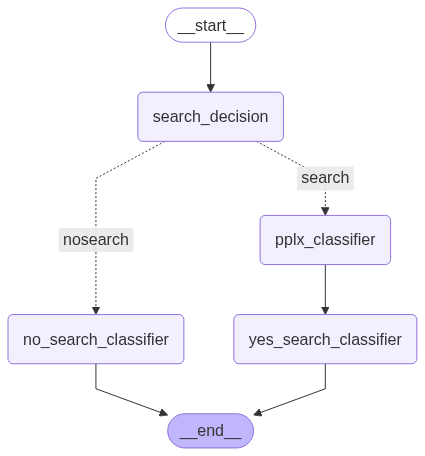

In [3]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print("cannot render")
    pass

In [4]:
# Example usage of the fact-checking graph
inputs = {
    "context": "Video transcript about scientific discoveries",
    "claim": "Albert Einstein developed the theory of relativity"
}


In [12]:
# Run the graph with our inputs using the async API
result = await graph.ainvoke(inputs)

FactChecker initialized.

Fact-checking Results:
An error occurred:  here is at calling perplexity api


In [13]:
print("Input claim:", inputs["claim"])
print("\nClaim type:", result["claim_type"])
print("Fact check result:", result["fact_check_result"])

Input claim: Albert Einstein developed the theory of relativity

Claim type: factual
Fact check result: The claim that Albert Einstein developed the theory of relativity is factual and correct. Einstein is widely recognized for formulating both the special theory of relativity in 1905 and the general theory of relativity in 1915.
